# Section 3.5 — Two-sample hypothesis tests

This notebook contains the code examples from [Section 3.5 Two-sample hypothesis tests]() of the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# Ensure required Python modules are installed
%pip install --quiet numpy scipy seaborn pandas ministats

Note: you may need to restart the kernel to use updated packages.


In [2]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Plot helper functions
from ministats import nicebins
from ministats import plot_pdf
from ministats.utils import savefigure

# Stats helper functions
from ministats import tailvalues
from ministats import tailprobs

In [4]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc={"font.family": "serif",
        "font.serif": ["Palatino", "DejaVu Serif", "serif"],
        "figure.figsize": (5, 1.6)},
)
%config InlineBackend.figure_format = 'retina'

<Figure size 640x480 with 0 Axes>

In [5]:
# Simple float __repr__  
if int(np.__version__.split(".")[0]) >= 2:
    np.set_printoptions(legacy='1.25')

# set random seed for repeatability
np.random.seed(42)

In [6]:
# Download datasets/ directory if necessary
from ministats import ensure_datasets
ensure_datasets()

$\def\stderr#1{\mathbf{se}_{#1}}$
$\def\stderrhat#1{\hat{\mathbf{se}}_{#1}}$
$\newcommand{\Mean}{\textbf{Mean}}$
$\newcommand{\Var}{\textbf{Var}}$
$\newcommand{\Std}{\textbf{Std}}$
$\newcommand{\Freq}{\textbf{Freq}}$
$\newcommand{\RelFreq}{\textbf{RelFreq}}$
$\newcommand{\DMeans}{\textbf{DMeans}}$
$\newcommand{\Prop}{\textbf{Prop}}$
$\newcommand{\DProps}{\textbf{DProps}}$

$$
\newcommand{\CI}[1]{\textbf{CI}_{#1}}
\newcommand{\CIL}[1]{\textbf{L}_{#1}}
\newcommand{\CIU}[1]{\textbf{U}_{#1}}
\newcommand{\ci}[1]{\textbf{ci}_{#1}}
\newcommand{\cil}[1]{\textbf{l}_{#1}}
\newcommand{\ciu}[1]{\textbf{u}_{#1}}
$$


(this cell contains the macro definitions like $\stderr{\overline{\mathbf{x}}}$, $\stderrhat{}$, $\Mean$, ...)

## Definitions


- **Populations**.
    We'll label the two unknown populations $X$ and $Y$.
    and assume the arbitrary model family $\mathcal{M}$ with mean parameter
    $X \sim \mathcal{M}(\mu_X)$ and $Y \sim \mathcal{M}(\mu_Y)$.

- **Parameters**.
    The means of the two populations $\mu_X$ and $\mu_Y$ are unknown,
    and what we want to study...

- **Samples**.
    We assume the two samples $\mathbf{x} = (x_1, x_2, \ldots, x_n)$
    and $\mathbf{y} = (y_1, y_2, \ldots, y_m)$
    are randomly selected from the populations $X$ and $Y$.

- **Estimate** (statistic) $\hat{d} = \overline{\mathbf{x}} - \overline{\mathbf{y}}$:
    the difference between means of the two samples $\mathbf{x}$ and $\mathbf{y}$.

- **Estimator** $\DMeans$:
    the function  that computes the difference between means from two samples,
    $\hat{d} = \DMeans(\mathbf{x},\mathbf{y}) =  \overline{\mathbf{x}} - \overline{\mathbf{y}}$.
    the function we use to compute the estimate $\hat{d}$.

- **Sampling distribution** $\hat{D} = \DMeans(\mathbf{X}, \mathbf{Y})$:
    the difference between means computed from two random samples $\mathbf{X}$ and $\mathbf{Y}$.



In [7]:
def mean(sample):
    return sum(sample) / len(sample)

def var(sample):
    xbar = mean(sample)
    sumsqdevs = sum([(xi-xbar)**2 for xi in sample])
    return sumsqdevs / (len(sample)-1)

def std(sample):
    s2 = var(sample)
    return np.sqrt(s2)

def dmeans(xsample, ysample):
    dhat = mean(xsample) - mean(ysample)
    return dhat

## Comparing two groups

Description of the problem: compare two group based on sample means computed from each group.

### Computing $p$-values

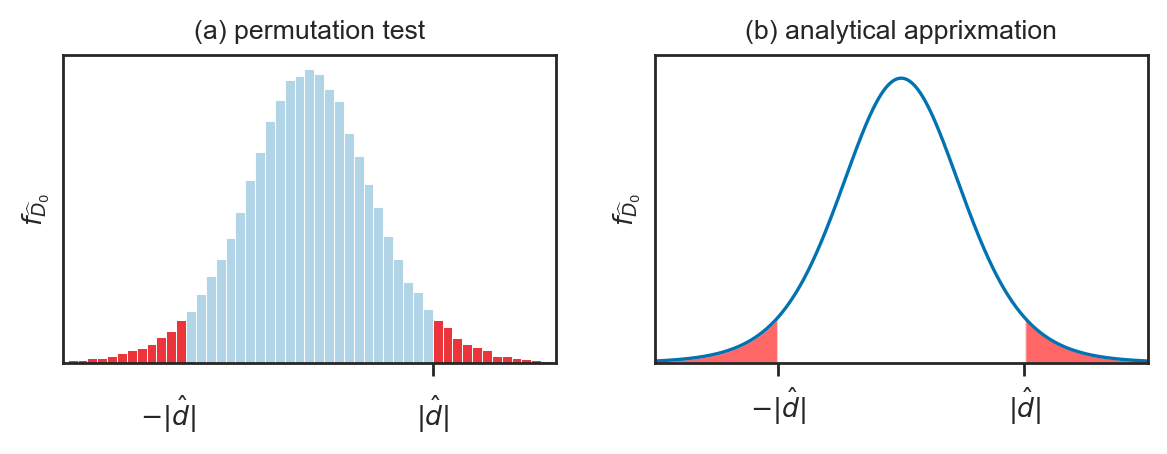

In [8]:
from ministats.book.figures import plot_panel_pvalue_D0_hist_and_dist

fig = plot_panel_pvalue_D0_hist_and_dist();

## Permutation test for comparing two populations

The **permutations test** is a computational approach for comparing two group.
The permutation test takes it's name from the action of mixing up the group-membership labels
and computing a statistic which is a way to generate samples from the null hypothesis
in situations where the null hypothesis states there is no difference between two groups.

#### Permutations

In [9]:
np.random.seed(43)
np.random.permutation([1,2,3,4,5,6,7])

array([4, 6, 3, 7, 2, 1, 5])

In [10]:
np.random.seed(45)
np.random.permutation([1,2,3,4,5,6,7])

array([6, 3, 2, 1, 5, 7, 4])

#### Resampling under the null hypothesis

In [11]:
def resample_under_H0(xsample, ysample):
    """
    Generate new samples from a random permutation of
    the values in the samples `xsample` and `xsample`.
    """
    values = np.concatenate((xsample, ysample))
    pvalues = np.random.permutation(values)
    pxsample = pvalues[0:len(xsample)]
    pysample = pvalues[len(xsample):]
    return pxsample, pysample

In [12]:
# example 1
np.random.seed(43)
resample_under_H0([1,2,3], [4,5,6,7])

(array([4, 6, 3]), array([7, 2, 1, 5]))

In [13]:
# example 2
np.random.seed(45)
resample_under_H0([1,2,3], [4,5,6,7])

(array([6, 3, 2]), array([1, 5, 7, 4]))

The function `resample_under_H0` gives us a way to generate samples from the null hypothesis.
We can then compute the value of the `dmeans` statistic for these samples. We used the assumption of "no difference" under the null hypothesis, and translated this to the "forget the labels" interpretation.

### Example 5P: electricity prices

The probability model under the alternative hypothesis
describes two populations with different parameters:

$$
   H_A: \qquad X_W = \mathcal{N}({\color{blue}{\mu_W}, \sigma_W})
   \quad \textrm{and} \quad
   X_{E} = \mathcal{N}({\color{orange}{\mu_{E}}, \sigma_{E}})
$$

Under the null hypothesis the populations have the same mean:

$$ 
   H_0: \qquad X_W = \mathcal{N}({\color{red}{\mu_0}, \sigma_W})
   \quad \textrm{and} \quad
   X_{E} = \mathcal{N}({\color{red}{\mu_0}, \sigma_{E}})
$$









In [14]:
eprices = pd.read_csv("datasets/eprices.csv")
eprices

,loc,price
0,East,7.7
1,East,5.9
2,East,7.0
3,East,4.8
4,East,6.3
5,East,6.3
6,East,5.5
7,East,5.4
8,East,6.5
9,West,11.8


In [15]:
eprices.groupby("loc")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
loc,,,,,,,,
East,9.0,6.155556,0.877655,4.8,5.5,6.3,6.5,7.7
West,9.0,9.155556,1.562139,6.8,8.3,8.6,10.0,11.8


In [16]:
pricesW = eprices[eprices["loc"]=="West"]["price"]
pricesE = eprices[eprices["loc"]=="East"]["price"]

# 1. Calculate the observed difference between means
dprice = dmeans(pricesW, pricesE)
dprice

3.0000000000000018

Our goal is to determine how *likely* or *unlikely* the observed value $\hat{d}=3$
is under the null hypothesis $H_0$.
This means we need to obtain the sampling distribution of $\hat{D}$ under $H_0$,
which we can do using the permutation test.

Let's look at some of the differences we can expect to observe under $H_0$.

In [17]:
#######################################################
np.random.seed(31)
# generate new samples by shuffling the labels
ppricesW, ppricesE = resample_under_H0(pricesW, pricesE)

# Compute the difference in means for the bootstrap samples
pdhat0 = dmeans(ppricesW, ppricesE)
pdhat0

1.6444444444444475

#### Running a permutation test

We can repeat the resampling procedure `10000` times to get the sampling distribution of $\widehat{D}_0$ under $H_0$,
as illustrated in the code procedure below.

In [18]:
np.random.seed(42)

# 2. Obtain the sampling distribution under H0
P = 10000
pdhats0 = []
for i in range(0, P):
    ps1, ps2 = resample_under_H0(pricesW, pricesE)
    pdhat0 = dmeans(ps1, ps2)
    pdhats0.append(pdhat0)

Now that we have the sampling distribution $\widehat{D}_0$,
we can see where the observed value $\hat{d}= 3$ `=dprice` falls within this distribution.
The $p$-value is the probability of observing value `dprice=3` or more extreme under the null hypothesis.

In [19]:
# 3. Compute the p-value 
tails = tailvalues(pdhats0, dprice)
pvalue = len(tails) / len(pdhats0)
pvalue

0.0002

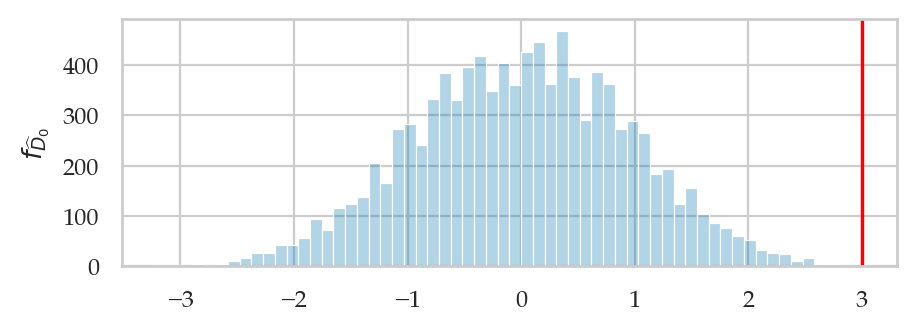

In [20]:
# plot the sampling distribution in blue
bins = nicebins(pdhats0, dprice)
ax = sns.histplot(pdhats0, bins=bins, alpha=0.3)

# plot red line for the observed statistic
plt.axvline(dprice, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, ax=ax, bins=bins, color="red")
ax.set_ylabel(r"$f_{\widehat{D}_0}$");

#### Effect size estimates

In [21]:
dprice = dmeans(pricesW, pricesE)
dprice

3.0000000000000018

The bootstrap confidence interval for the effect size 
$\ci{\Delta,0.9}^*$ tells us a range of plausible values for the effect size.

In [22]:
from ministats import ci_dmeans

np.random.seed(45)
ci_dmeans(pricesW, pricesE, alpha=0.1, method="b")

[2.0777777777777775, 3.9555555555555557]

The 90% confidence interval $\ci{\Delta,0.9}^* = [2.08, 3.96]$ describes an interval of numbers
that should contain the difference between group means $\Delta$ at least 90\% of the time:

$$
    \textrm{Pr}_{\mathbf{X}}\big(\{ \Delta \in \ci{\Delta,0.9}^* \}\big) \geq 0.9.
$$


### Reusable function

In [23]:
def permutation_test_dmeans(xsample, ysample, P=10000):
    # 1. Compute the observed difference between means
    obsdhat = dmeans(xsample, ysample)

    # 2. Get sampling dist. of `dmeans` under H0
    pdhats0 = []
    for i in range(0, P):
        psx, psy = resample_under_H0(xsample, ysample)
        pdhat0 = dmeans(psx, psy)
        pdhats0.append(pdhat0)

    # 3. Compute the p-value
    tails = tailvalues(pdhats0, obsdhat, alt="two-sided")
    pvalue = len(tails) / len(pdhats0)
    return pvalue

In [24]:
np.random.seed(42)

permutation_test_dmeans(pricesW, pricesE)

0.0002

### Example 6P: lecture and debate curriculums

In [25]:
students = pd.read_csv("datasets/students.csv")
students

,student_ID,background,curriculum,effort,score
0,1,arts,debate,10.96,75.0
1,2,science,lecture,8.69,75.0
2,3,arts,debate,8.60,67.0
3,4,arts,lecture,7.92,70.3
4,5,science,debate,9.90,76.1
5,6,business,debate,10.80,79.8
6,7,science,lecture,7.81,72.7
7,8,business,lecture,9.13,75.4
8,9,business,lecture,5.21,57.0
9,10,science,lecture,7.71,69.0


In [26]:
students.groupby("curriculum")["score"].describe()

,count,mean,std,min,25%,50%,75%,max
curriculum,,,,,,,,
debate,8.0,76.462500,10.519633,62.9,69.55,75.55,80.925,96.2
lecture,7.0,68.142857,7.758406,57.0,63.30,70.30,73.850,75.4


In [27]:
studentsD = students[students["curriculum"]=="debate"]
studentsL = students[students["curriculum"]=="lecture"]
scoresD = studentsD["score"]
scoresL = studentsL["score"]

# observed difference between score means
dscore = dmeans(scoresD, scoresL)
dscore

8.319642857142867

Our goal is to determine how *likely* or *unlikely* this observed value $\hat{d}_s=8.32$ is under the null hypothesis $H_0$. This means we need to obtain the sampling distribution of $\hat{D}_0$ under $H_0$, which we can do using the permutation test.

In [28]:
np.random.seed(43)
pvalue = permutation_test_dmeans(scoresD, scoresL)
pvalue

0.1115

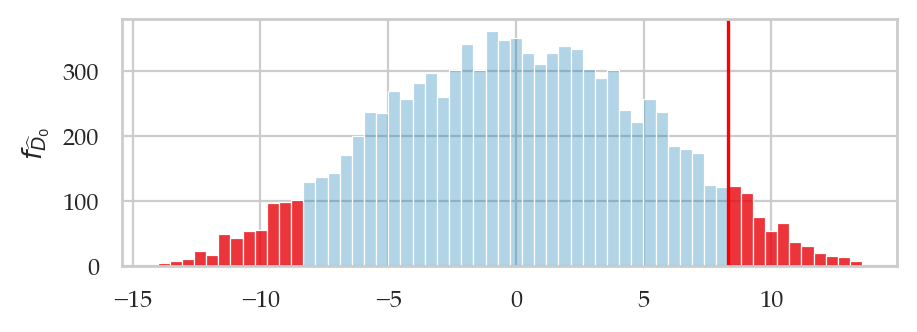

In [29]:
# generate sampling distribution under H0
np.random.seed(43)
pdhats = []
P = 10000
for i in range(0, P):
    rs1, rs2 = resample_under_H0(scoresD, scoresL)
    pdhat = dmeans(rs1, rs2)
    pdhats.append(pdhat)
    
# plot the sampling distribution in blue
bins = nicebins(pdhats, dscore)
ax = sns.histplot(pdhats, bins=bins, alpha=0.3)

# plot red line for the observed statistic
plt.axvline(dscore, color="red")

# plot the values that are equal or more extreme in red
tails = tailvalues(pdhats, dscore)
# print( len(tails) / len(pdhats) )
sns.histplot(tails, bins=bins, ax=ax, color="red")
ax.set_ylabel(r"$f_{\widehat{D}_0}$");

## Analytical approximation methods

We'll now look at another approach for computing the sampling distribution of the difference between means estimator, using an analytical approximations based on Student's $t$-distribution.
This is called the "two-sample $t$-test" and it is procedure most commonly taught approach in STATS 101 courses.

How likely or unlikely is the observed difference $d=3$ under the null hypothesis $H_0$?

- Analytical approximations are math models for describing the sampling distribution under $H_0$

  - Real sampling distributions: obtained by repeated sampling from $H_0$  
  - Analytical approximation: math model based on estimated parameters


- Based on this assumption we can use the theoretical model for the difference between group means
  (we assumed the two unknown populations are normally distributed),
  we can obtain a **closed form expression** for the sampling distribution of $D_0$.


- In particular, the probability model for the two groups under $H_0$ are:
  
  $$ 
       H_0: \qquad X = \mathcal{N}({\color{red}{\mu_0}}, \sigma_X)
       \quad \textrm{and} \quad
       Y = \mathcal{N}({\color{red}{\mu_0}}, \sigma_Y), \quad
  $$
  
  from which we can derive the model for $D = \overline{\mathbf{X}} - \overline{\mathbf{Y}}$:
  
  $$ 
     D_0  \sim \mathcal{N}\!\left( {\color{red}{0}}, \;  \stderr{\hat{d}} \right)
  $$
  In words, the sampling distribution of the difference between group means is
  normally distributed with mean $\Delta = 0$ and standard deviation $\stderrhat{\hat{d}}$,
  described by the formula:
  
  $$
	\stderr{\hat{d}}
		% \; = \; \sqrt{  \stderr{\overline{\mathbf{x}}}^2 + \stderr{\overline{\mathbf{y}}}^2 }
    	   = \sqrt{ \tfrac{\sigma_X^2}{n} + \tfrac{\sigma_Y^2}{m} }\;.
  $$
  The standard error of the difference between means
  depends on the variance of the two groups $\sigma_X^2$ and $\sigma_Y^2$.
  Recall we've seen this expression earlier in Section 3.1 and Section 3.2 as well.

- **Problem 1:** the population variances $\sigma_X^2$ and $\sigma_Y^2$ are unknown,
  and we only have the estimated variances $s_{\mathbf{x}}$ and $s_{\mathbf{y}}$,
  which we calculated from the samples $\mathbf{x}$ and $\mathbf{y}$.

- **Solution 1:** use **plug in estimate** and 
  We can obtain an approximation to the standard error of the difference between means estimator
  using the plug-in principle,
  which states we can use search-and-replace the population parameters
  $\sigma_X^2$ and $\sigma_Y^2$ with the estimates $s_{\mathbf{x}}$ and $s_{\mathbf{y}}$:
  
  $$
	\stderrhat{\hat{d}}
		% \; = \; \sqrt{  \stderrhat{\overline{\mathbf{x}}}^2 + \stderrhat{\overline{\mathbf{y}}}^2 }
    	   = \sqrt{ \tfrac{s_{\mathbf{x}}^2}{n} + \tfrac{s_{\mathbf{y}}^2}{m} }\;.
  $$


- **Problem 2:** the estimated standard error $\stderrhat{\hat{d}}$
  tends to underestimate the true standard error $\stderr{\hat{d}}$,
  so when we use the basic normal model
  $\mathcal{N}\!\left(\tt{loc}=0, \tt{scale}=\stderrhat{\hat{d}} \right)$
  the approximation is off (not enough weight in the tails).

- **Solution 2:** use **Student's $t$-distribution**.
  We can define a new model for the $D_0 = \overline{\mathbf{X}} - \overline{\mathbf{Y}}$
  based on Student's $t$-distribution:
  $$ 
     D_0  \sim \mathcal{T}\!\left(\tt{df}=\nu_d, \; \tt{loc}={\color{red}{0}}, \;  \tt{scale}=\stderrhat{\hat{d}} \right)
  $$
  In words, the sampling distribution of the difference between group means
  can be modeled as Student's $t$-distribution with $\nu_d$ degrees of freedom,
  centered at $0$, with scale parameter $\stderrhat{\hat{d}}$.

- The **degrees of freedom** parameter, denoted $\nu_d$ (Greek letter *nu*) in equations (`df` in code)
  determines the "weight" in the tails of the distribution.
  It is computed by a complicated formula that depends on the sample sizes $n$ and $m$,
  and the sample standard deviations $s_{\mathbf{x}}$ and $s_{\mathbf{y}}$.

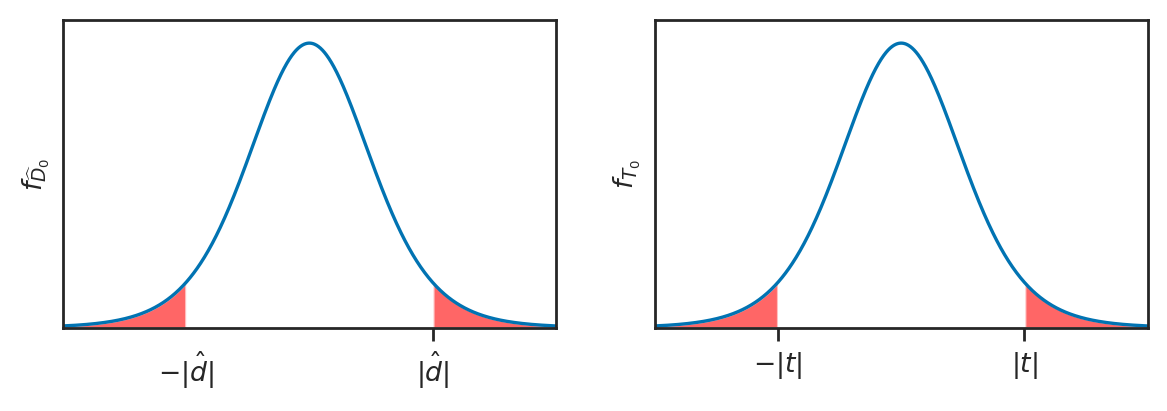

In [30]:
from ministats.book.figures import plot_panel_pvalue_D0_and_T0
plot_panel_pvalue_D0_and_T0();

### Example 5T: comparing East and West electricity prices

In [31]:
eprices = pd.read_csv("datasets/eprices.csv")
pricesW = eprices[eprices["loc"]=="West"]["price"]
pricesE = eprices[eprices["loc"]=="East"]["price"]

# Calculate the observed difference between means
dprice = dmeans(pricesW, pricesE)
dprice

3.0000000000000018

#### Two-sample t-test

We'll now show the data, probability modeling, and calculation steps 
of the "two-sample $t$-test for comparing group means.
The two-sample [$t$-test](https://statkat.com/stattest.php?&t=9)
is also known as Welch's t-test.

<!-- which allows the variances in the two groups to be different. 
We'll talk about the $t$-test with pooled variances later on. 
Welch's $t$-test differs only in steps 4 through 6 as shown below:
-->

In [32]:
# Calculate the sample size and the standard deviation for each group
nW, nE = len(pricesW), len(pricesE)
stdW, stdE = std(pricesW), std(pricesE)

In [33]:
# Compute the standard error of the estimator D
seD = np.sqrt(stdW**2/nW + stdE**2/nE)
seD

0.5972674401486561

In [34]:
# Compute the value of the t-statistic
obst = (dprice - 0) / seD
obst

5.022875513276466

In [35]:
from ministats import calcdf
    
# Obtain the degrees of freedom from the crazy formula
dfD = calcdf(stdW, nW, stdE, nE)
dfD

12.59281702723103

In [36]:
# Calculate the p-value

from scipy.stats import t as tdist
rvT0 = tdist(df=dfD)
from ministats import tailprobs
pvalue = tailprobs(rvT0, obst, alt="two-sided")
pvalue

0.00025703383372176815

In [37]:
# # SKIP BECAUSE TOO SMALL TO SEE
# _, ax = calc_prob_and_plot_tails(rvT0, -obst, obst, xlims=[-6,6])
# ax.set_title(None)
# ax.set_xlabel("$t$")
# ax.set_ylabel("$f_{T_0}$");

#### Effect size estimates

In [38]:
dprice = dmeans(pricesW, pricesE)
dprice

3.0000000000000018

The confidence interval for the effect size 
$\ci{\Delta,0.9}$ tells us a range of plausible values for the effect size.

In [39]:
from ministats import ci_dmeans

ci_dmeans(pricesW, pricesE, alpha=0.1, method="a")

[1.9396575883681466, 4.060342411631854]

The 90% confidence interval $\ci{\Delta,0.9} = [1.94, 4.06]$ describes an interval of numbers
that should contain the difference between group means $\Delta$ at least 90\% of the time:

$$
    \textrm{Pr}_{\mathbf{X}}\big(\{ \Delta \in \ci{\Delta,0.9} \}\big) \geq 0.9.
$$


### Reusable procedure for two-sample $t$-test

In [40]:
def ttest_dmeans(xsample, ysample):
    # Calculate the observed difference between means
    obsdhat = mean(xsample) - mean(ysample)

    # Calculate the sample sizes and the stds
    n, m = len(xsample), len(ysample)
    sx, sy = std(xsample), std(ysample)

    # Calculate the standard error, the degrees of
    # freedom, the null model, and the t-statistic
    seD = np.sqrt(sx**2/n + sy**2/m)
    dfD = calcdf(sx, n, sy, m)
    obst = (obsdhat - 0) / seD

    # Calculate the p-value from the t-distribution
    rvT0 = tdist(df=dfD)
    pvalue = tailprobs(rvT0, obst, alt="two-sided")
    return pvalue

Verify we get the same $p$-value
when using the standard error formula.

In [41]:
ttest_dmeans(pricesW, pricesE)

0.00025703383372176815

### Example 6T: comparing rural and urban sleep scores

In [42]:
students = pd.read_csv("datasets/students.csv")
# students
# students.groupby("curriculum")["score"].describe()

scoresD = students[students["curriculum"]=="debate"]["score"]
scoresL = students[students["curriculum"]=="lecture"]["score"]

# observed difference between score means
dscores = dmeans(scoresD, scoresL)
dscores

8.319642857142867

In [43]:
ttest_dmeans(scoresD, scoresL)

0.10307495448387402

In [44]:
# T-TEST ANALYSIS
nD, nL = len(scoresD), len(scoresL)
stdD, stdL = std(scoresD), std(scoresL)
seDDL = np.sqrt(stdD**2/nD + stdL**2/nL)

obstDL = (dscores - 0) / seDDL

from ministats import calcdf
dfDL = calcdf(stdD, nD, stdL, nL)
rvT0DL = tdist(df=dfDL)
pvalueDL = tailprobs(rvT0DL, obstDL, alt="two-sided")
pvalueDL

0.10307495448387402

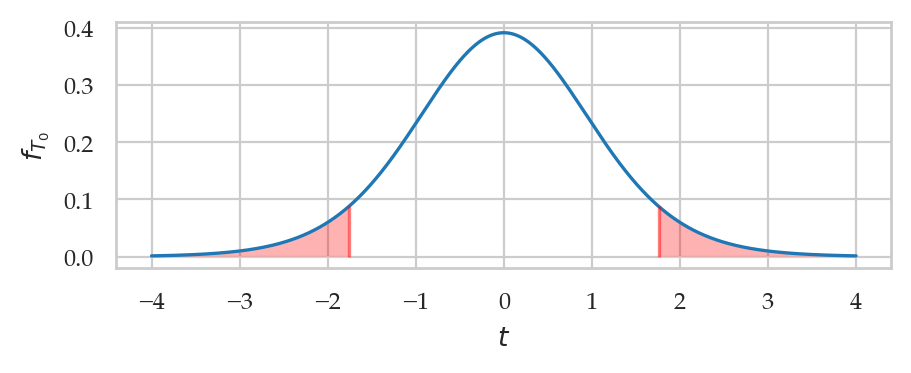

In [45]:
from ministats import calc_prob_and_plot_tails
_, ax = calc_prob_and_plot_tails(rvT0DL, -obstDL, obstDL, xlims=[-4,4])
ax.set_title(None)
ax.set_xlabel("$t$")
ax.set_ylabel("$f_{T_0}$");

## Alternative calculation methods

### Two-sample $t$-test using pooled variance
#### Pooled variance formulas


<!--

There are two common ways to obtain an approximation for $\sigma^2_D$:
  - Unpooled variance: $\sigma^2_D \approx s^2_u = \tfrac{s^2_S}{n_S} + \tfrac{s^2_{NS}}{n_{NS}}$
    (follows from the general rule of probability theory)
  - Pooled variance: $\sigma^2_D \approx s^2_p =  \frac{(n_S-1)s_S^2 \; + \; (n_{NS}-1)s_{NS}^2}{n_S + n_{NS} - 2}$
    (takes advantage of assumption that both samples come from the same population under $H_0$)
--> 

#### Example 5T revisited with pooled variance

In [46]:
# TODO make self contained

In [47]:
# Compute the pooled variance and standard error of estimator D
varp = ((nW-1)*stdW**2 + (nE-1)*stdE**2) / (nW + nE - 2)
stdp = np.sqrt(varp)
seDp = stdp * np.sqrt(1/nW + 1/nE)
seDp

0.5972674401486561

In [48]:
# Compute the value of the t-statistic
obstp = (dprice - 0) / seDp
obstp

5.022875513276466

In [49]:
# Obtain the degrees of freedom
dfDp = nW + nE - 2
dfDp

16

In [50]:
from scipy.stats import t as tdist
from ministats import tailprobs

# Calculate the p-value
rvT0p = tdist(df=dfDp)
pvaluep = tailprobs(rvT0p, obstp, alt="two-sided")
pvaluep

0.00012497067987674856

### Using `scipy.stats.ttest_ind` for two-sample $t$-tests

Alternatively,
we can use `scipy.stats.ttest_ind` to obtain the $p$-value.

Use `equal_var=False` to obtain the Welsh value.

In [51]:
# ALT. compute using existing function in `scipy.stats`
from scipy.stats import ttest_ind
res1 = ttest_ind(pricesW, pricesE, equal_var=False)
res1.pvalue

0.00025703383372176116

Use `equal_var=True` to obtain the pooled variance value.

In [52]:
# ALT. compute using existing function in `scipy.stats`
from scipy.stats import ttest_ind
res2 = ttest_ind(pricesW, pricesE, equal_var=True)
res2.pvalue

0.00012497067987678488

### Using `scipy.stats.ttest_ind` for permutation test

You can use the SciPy implementation of permutation test,
by calling `ttest_ind(..., permutations=10000)` to perform a permutation test, then obtain the $p$-value.

In [53]:
from scipy.stats import ttest_ind

np.random.seed(42)
ttest_ind(pricesW, pricesE, permutations=10000).pvalue

/var/folders/yp/48zx9brn6mj6vmy50smb844w0000gn/T/ipykernel_69065/472059880.py:4: DeprecationWarning: Arguments {'permutations'} are deprecated, whether passed by position or keyword. They will be removed in SciPy 1.17.0. Use ``method`` to perform a permutation test.
  ttest_ind(pricesW, pricesE, permutations=10000).pvalue


0.00029997000299970003

Note the $p$-value we obtained form the two methods may be different.
This can happen when using the permutations test,
because we use randomness as part of the calculation.

### Using `statsmodels` for two-sample $t$-tests

In [54]:
import statsmodels.stats.api as sms

statsW = sms.DescrStatsW(pricesW)
statsE = sms.DescrStatsW(pricesE)
cm = sms.CompareMeans(statsW, statsE)

# Welch's t-test
cm.ttest_ind(alternative="two-sided", usevar="unequal")

(5.022875513276465, 0.00025703383372176073, 12.592817027231032)

In [55]:
# T-test with pooled variance
cm.ttest_ind(alternative="two-sided", usevar="pooled")

(5.022875513276465, 0.00012497067987678488, 16.0)

## Explanations

### Statistical modelling assumptions


- INDEP:
- NORMAL:
- LARGEn:
- EQVAR:

### Standardized effect size

It is sometimes useful to report the effect size using a "standardized" measure for effect sizes.

Cohen's $d$ is one such measure, and it is defined as the difference between two means divided by the pooled standard deviation.

$$
  d = \frac{\overline{\mathbf{x}} - \overline{\mathbf{y}} }{ s_{p} }.
$$
where the pooled variance is defined as
$s_{p}^2 = [(n -1)s_{\mathbf{x}}^2 + (m -1)s_{\mathbf{y}}^2]/(n + m -2)$.


In [56]:
def cohend2(sample1, sample2):
    """
    Cohen's d measure of effect size for two independent samples.
    """
    n1, n2 = len(sample1), len(sample2)
    mean1, mean2 = mean(sample1), mean(sample2)
    var1, var2 = var(sample1), var(sample2)
    # calculate the pooled variance and std
    var_pooled = ((n1-1)*var1+(n2-1)*var2) / (n1+n2-2)
    std_pooled = np.sqrt(var_pooled)
    d = (mean1 - mean2) / std_pooled
    return d

We interpret the value of Cohen's $d$ using the [reference table](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d) of values:

| Cohen's d   | Effect size |
| ----------- | ----------- |
| 0.01        | very small  |
| 0.20        | small       |
| 0.50        | medium      |
| 0.80        | large       |


Effect size for mean deviation of kombucha Batch 04 from expected value $\mu_K=1000$.

In [57]:
cohend2(pricesW, pricesE)

2.3678062243290996

## Discussion
### Comparison to resampling methods

## Exercises

See notebook [exercises_35_two_sample_tests.ipynb](../exercises/exercises_35_two_sample_tests.ipynb).

## Links

* [Permutation Methods: A Basis for Exact Inference](https://projecteuclid.org/journals/statistical-science/volume-19/issue-4/Permutation-Methods-A-Basis-for-Exact-Inference/10.1214/088342304000000396.full) by Michael D. Ernst

* Nice animation https://commons.wikimedia.org/wiki/File:Permutation_test_example_animation.gif  
  via https://en.wikipedia.org/wiki/Permutation_test